In [ ]:
# INI COLLAB BUAT MODEL RAM

#PEMODELAN UNTUK KLASIFIKASI OBJECT RAM 

## 1. Import Library

In [ ]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from tensorflow import keras
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import img_to_array, load_img
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import xml.etree.ElementTree as ET
from tensorflow.keras.applications import MobileNet

In [ ]:
!pip install tensorflowjs


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

## 2. Tautan Collab dengan Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Ambil data dari directory Gdrive

In [ ]:
train_dir = '/content/drive/MyDrive/Bangkit/WOWRACK/RAM/train'
val_dir = '/content/drive/MyDrive/Bangkit/WOWRACK/RAM/valid'
test_dir = '/content/drive/MyDrive/Bangkit/WOWRACK/RAM/test'

lentrain = len(os.listdir(train_dir))

In [ ]:
# Tentukan jumlah kelas dalam dataset Anda
num_classes = 1 # Ganti dengan jumlah kelas yang sesuai

# Tentukan dimensi input yang diharapkan oleh model MobileNet
input_shape = (224, 224, 3)

# Muat MobileNet sebagai model dasar
base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
# Bekukan layer-base_model agar tidak terlibat dalam pelatihan
base_model.trainable = False

# Buat model akhir dengan menambahkan beberapa layer di atas base_model
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1025      
                                                                 
Total params: 3,229,889
Trainable params: 1,025
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
# Fungsi untuk membaca file XML anotasi
def read_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    boxes = []
    labels = []

    for object in root.findall('object'):
        name = object.find('name').text
        xmin = int(object.find('bndbox/xmin').text)
        ymin = int(object.find('bndbox/ymin').text)
        xmax = int(object.find('bndbox/xmax').text)
        ymax = int(object.find('bndbox/ymax').text)

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(name)

    return boxes, labels

In [ ]:
# Mendapatkan daftar file gambar dan anotasi dalam folder
def get_image_annotation_files(folder):
    image_files = []
    annotation_files = []
    for file in os.listdir(folder):
        if file.endswith('.jpg'):
            image_files.append(file)
            annotation_file = os.path.splitext(file)[0] + '.xml'
            annotation_files.append(annotation_file)

    return image_files, annotation_files

In [ ]:
# Muat data gambar dan anotasi dari direktori
train_image_files, train_annotation_files = get_image_annotation_files(train_dir)
val_image_files, val_annotation_files = get_image_annotation_files(val_dir)
test_image_files, test_annotation_files = get_image_annotation_files(test_dir)
train_boxes = []
train_labels = []
for annotation_file in train_annotation_files:
    boxes, labels = read_annotation(os.path.join(train_dir, annotation_file))
    train_boxes.append(boxes)
    train_labels.append(labels)

val_boxes = []
val_labels = []
for annotation_file in val_annotation_files:
    boxes, labels = read_annotation(os.path.join(val_dir, annotation_file))
    val_boxes.append(boxes)
    val_labels.append(labels)

test_boxes = []
test_labels = []
for annotation_file in test_annotation_files:
    boxes, labels = read_annotation(os.path.join(test_dir, annotation_file))
    test_boxes.append(boxes)
    test_labels.append(labels)

In [ ]:
# Tentukan parameter untuk augmentasi data gambar
datagen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

## 4. Buat Augmentasi dengan API IamgeDataGenerator

In [ ]:
# train_dir = r'/content/drive/MyDrive/Bangkit/WOWRACK/dataset/RAMXML/train'
# val_dir = r'/content/drive/MyDrive/Bangkit/WOWRACK/dataset/RAMXML/valid'
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=False  # Nonaktifkan pengacakan agar anotasi tetap sesuai dengan gambar
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Nonaktifkan pengacakan agar anotasi tetap sesuai dengan gambar
)

tes_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

train_generator.annotation_boxes = train_boxes
train_generator.annotation_labels = train_labels

val_generator.annotation_boxes = val_boxes
val_generator.annotation_labels = val_labels


Found 440 images belonging to 1 classes.
Found 10 images belonging to 1 classes.
Found 28 images belonging to 1 classes.


In [ ]:
# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Latih model
history = model.fit(
    train_generator,
    epochs=10,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


14/14 [==============================] - 19s 664ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/10
14/14 [==============================] - 3s 222ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/10
14/14 [==============================] - 4s 252ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 4s 219ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 3s 223ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 4s 267ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 3s 225ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_

In [ ]:
epoch_avg_acc = sum(history.history['accuracy']) / len(history.history['accuracy'])
print("Epoch average accuracy: {:.2f}%".format(epoch_avg_acc * 100))

Epoch average accuracy: 100.00%


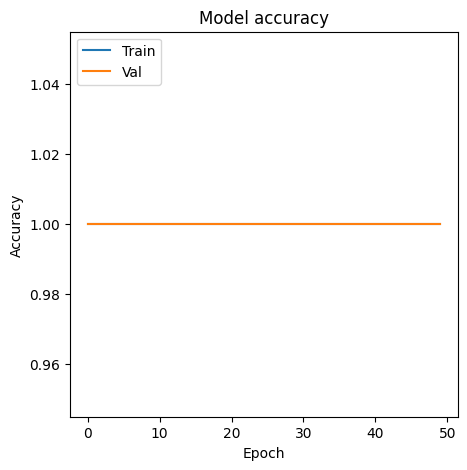

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

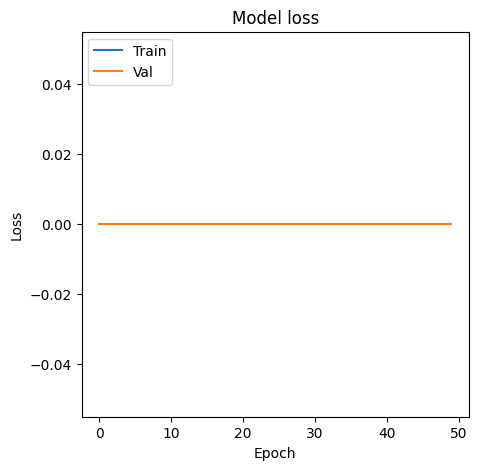

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(tes_generator)

1/1 [==============================] - 1s 834ms/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
target_names = ['Class 1']
print(classification_report(tes_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00        28

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



In [ ]:
test_loss, test_accuracy = model.evaluate(tes_generator)
print("test loss:",test_loss)
print("test acc:",test_accuracy)

1/1 [==============================] - 1s 878ms/step - loss: 0.0000e+00 - accuracy: 1.0000
test loss: 0.0
test acc: 1.0


In [ ]:
cm = confusion_matrix(tes_generator.classes, y_pred)
cm

array([[28]])

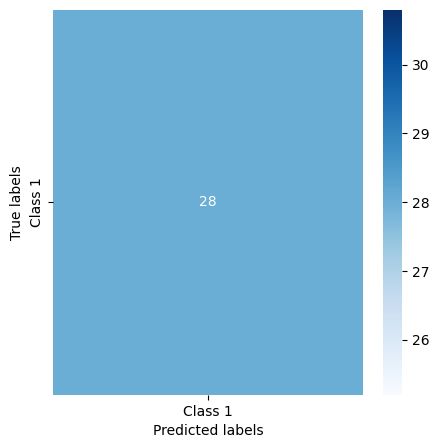

In [ ]:
# Create heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(target_names)
ax.set_yticklabels(target_names)
plt.show()

1/1 [==============================] - 1s 807ms/step
Predicted Class: 0


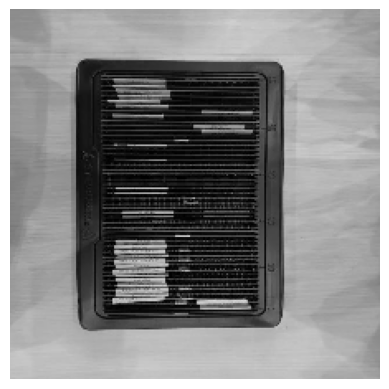

In [ ]:
import numpy as np

# Path ke file yang akan diuji
#file_path = "/content/drive/MyDrive/Bangkit/WOWRACK/dataset/Person/Test/2/1_Sample2_13.jpg"
file_path = r'/content/drive/MyDrive/Bangkit/WOWRACK/RAM/test/ram/20230505_133653_jpg.rf.76715a05de21c55bfe74ec073fc27b4b.jpg'
# Membaca dan memproses gambar
img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
x = tf.keras.preprocessing.image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0  # Normalisasi

# Melakukan prediksi
predictions = model.predict(x)

# Mendapatkan label kelas dengan nilai probabilitas tertinggi
predicted_class = np.argmax(predictions[0])

plt.imshow(img)
plt.axis('off')
# Menampilkan hasil prediksi
print("Predicted Class:", predicted_class)
plt.show()

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
# Simpan model yang telah dilatih sebagai file Keras HDF5.
saved_model_path = "./my_ram_model.h5"
model.save(saved_model_path)

# Konversi model Keras HDF5 ke format TensorFlow.js.
!tensorflowjs_converter --input_format=keras {saved_model_path} /tmp/tfjs_model

2023-05-25 05:17:26.853041: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import tensorflow.keras as keras
import tensorflowjs as tfjs
path = '/content/my_ram_model.h5'
model = keras.models.load_model(path)
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/Bangkit/WOWRACK/RAM')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical', 
    subset='training',
    shuffle=False)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=input_shape[:2],
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False)

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=input_shape[:2],
#     batch_size=32,
#     class_mode='binary',
#     shuffle=True)

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

# Memuat model MobileNet yang telah dilatih pada dataset ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Menambahkan lapisan klasifikasi pada bagian atas model base MobileNet
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

# Membuat model baru dengan lapisan klasifikasi yang ditambahkan
model = Model(inputs=base_model.input, outputs=x)

# Membekukan lapisan base_model untuk mencegah pembelajaran ulang
for layer in base_model.layers:
    layer.trainable = False

# Kompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Melatih ulang (fine-tuning) model dengan dataset Anda
model.fit(train_images, train_labels, epochs=num_epochs, validation_data=(val_images, val_labels))

# Menggunakan model untuk mendeteksi objek pada gambar baru
predictions = model.predict(test_images)


## 5. Buat layer Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 32)       0

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=1e-6),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator)

Epoch 1/50
106/106 [==============================] - 129s 1s/step - loss: 0.7710 - accuracy: 0.2272 - val_loss: 0.6376 - val_accuracy: 0.9771
Epoch 2/50
106/106 [==============================] - 30s 279ms/step - loss: 0.5366 - accuracy: 1.0000 - val_loss: 0.4421 - val_accuracy: 1.0000
Epoch 3/50
106/106 [==============================] - 29s 279ms/step - loss: 0.3796 - accuracy: 1.0000 - val_loss: 0.3214 - val_accuracy: 1.0000
Epoch 4/50
106/106 [==============================] - 29s 277ms/step - loss: 0.2815 - accuracy: 1.0000 - val_loss: 0.2430 - val_accuracy: 1.0000
Epoch 5/50
106/106 [==============================] - 29s 276ms/step - loss: 0.2172 - accuracy: 1.0000 - val_loss: 0.1886 - val_accuracy: 1.0000
Epoch 6/50
106/106 [==============================] - 31s 291ms/step - loss: 0.1716 - accuracy: 1.0000 - val_loss: 0.1502 - val_accuracy: 1.0000
Epoch 7/50
106/106 [==============================] - 29s 275ms/step - loss: 0.1376 - accuracy: 1.0000 - val_loss: 0.1202 - val_accu

In [ ]:
epoch_avg_acc = sum(history.history['accuracy']) / len(history.history['accuracy'])
print("Epoch average accuracy: {:.2f}%".format(epoch_avg_acc * 100))

Epoch average accuracy: 98.45%


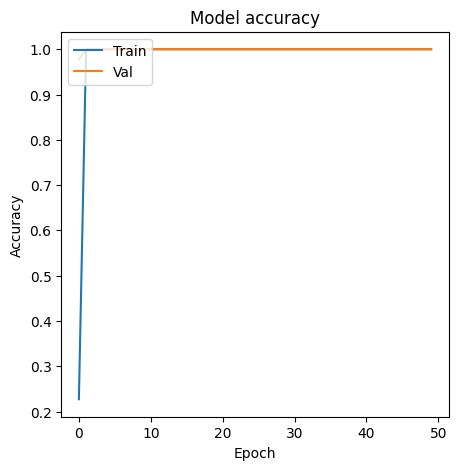

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

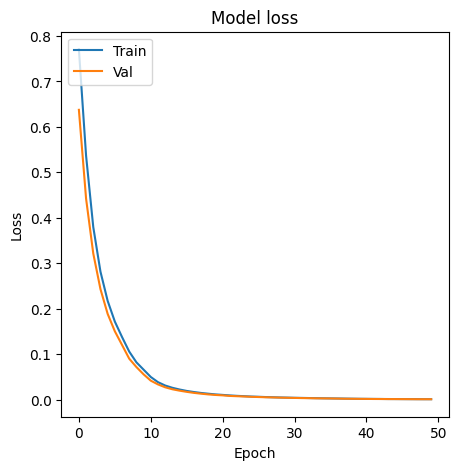

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_pred = model.predict(test_generator)

15/15 [==============================] - 43s 3s/step


In [ ]:
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
target_names = ['Class 1']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     Class 1       1.00      1.00      1.00       240

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print("test loss:",test_loss)
print("test acc:",test_accuracy)

15/15 [==============================] - 4s 282ms/step - loss: 3.8677e-04 - accuracy: 1.0000
test loss: 0.00038677031989209354
test acc: 1.0


In [ ]:
cm = confusion_matrix(test_generator.classes, y_pred)
cm

array([[240]])

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.9/189.9 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 23.1
    Uninstalling packaging-23.1:
      Successfully uninstalled packaging-23.1
  Attempting uninstall: flax
    Found existing installation: flax 0.6.9
    Uninstalling flax-0.6.9:
      Successfully uninstalled flax-0.6.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsmodels 0.13.5 requires packaging>=21.3, but you have packaging 20.9 which is incompatible.
xar

In [ ]:
# Simpan model yang telah dilatih sebagai file Keras HDF5.
saved_model_path = "./my_ram_model.h5"
model.save(saved_model_path)

# Konversi model Keras HDF5 ke format TensorFlow.js.
!tensorflowjs_converter --input_format=keras {saved_model_path} /tmp/tfjs_model

2023-05-23 01:36:23.490203: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
import tensorflow.keras as keras
import tensorflowjs as tfjs
path = '/content/my_ram_model.h5'
model = keras.models.load_model(path)
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/Bangkit/WOWRACK/dataset/ram')

